In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Load your models
model1 = load_model('/home/chirag/medical_classification_project/model_cnn.keras')  # input (150, 150)
model2 = load_model('/home/chirag/medical_classification_project/model_MobileNetV2_NonTrainable.keras')  # input (150, 150)
model3 = load_model('/home/chirag/medical_classification_project/model_MobileNetV2_Trainable.keras') # input (150, 150)
model4 = load_model('/home/chirag/medical_classification_project/model_VGG16.keras')  # input (224, 224)
model5 = load_model('/home/chirag/medical_classification_project/model_DenseNet121.keras')  # input (224, 224)


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator_150 = test_datagen.flow_from_directory(
    '/home/chirag/medical_classification_project/Data/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

test_generator_224 = test_datagen.flow_from_directory(
    '/home/chirag/medical_classification_project/Data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# True labels
y_true = test_generator_150.classes


Found 624 images belonging to 2 classes.


Found 624 images belonging to 2 classes.


In [15]:
# Make predictions
preds1 = model1.predict(test_generator_150).flatten()
preds2 = model2.predict(test_generator_150).flatten()
preds3 = model3.predict(test_generator_150).flatten()
preds4 = model4.predict(test_generator_224).flatten()
preds5 = model5.predict(test_generator_224).flatten()


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 388ms/step


In [17]:
# Individual model AUC scores
auc1 = roc_auc_score(y_true, preds1)
auc2 = roc_auc_score(y_true, preds2)
auc3 = roc_auc_score(y_true, preds3)
auc4 = roc_auc_score(y_true, preds4)
auc5 = roc_auc_score(y_true, preds5)

print(f"Model 1 AUC: {auc1}")
print(f"Model 2 AUC: {auc2}")
print(f"Model 3 AUC: {auc3}")
print(f"Model 4 AUC: {auc4}")
print(f"Model 5 AUC: {auc5}")


Model 1 AUC: 0.9387026079333772
Model 2 AUC: 0.9341442033749725
Model 3 AUC: 0.9567061143984221
Model 4 AUC: 0.9716085908393601
Model 5 AUC: 0.964486083716853


In [18]:
# Sum of AUCs
auc_sum = auc1 + auc2 + auc3 + auc4 + auc5

# Calculate normalized weights
w1 = auc1 / auc_sum
w2 = auc2 / auc_sum
w3 = auc3 / auc_sum
w4 = auc4 / auc_sum
w5 = auc5 / auc_sum

print(f"Model 1 Weight: {w1:.3f}")
print(f"Model 2 Weight: {w2:.3f}")
print(f"Model 3 Weight: {w3:.3f}")
print(f"Model 4 Weight: {w4:.3f}")
print(f"Model 5 Weight: {w5:.3f}")


Model 1 Weight: 0.197
Model 2 Weight: 0.196
Model 3 Weight: 0.201
Model 4 Weight: 0.204
Model 5 Weight: 0.202


In [19]:
# Weighted ensemble predictions
ensemble_preds = (w1 * preds1 + 
                  w2 * preds2 + 
                  w3 * preds3 + 
                  w4 * preds4 + 
                  w5 * preds5)

# Convert probabilities to binary predictions
ensemble_binary_preds = (ensemble_preds > 0.5).astype(int)


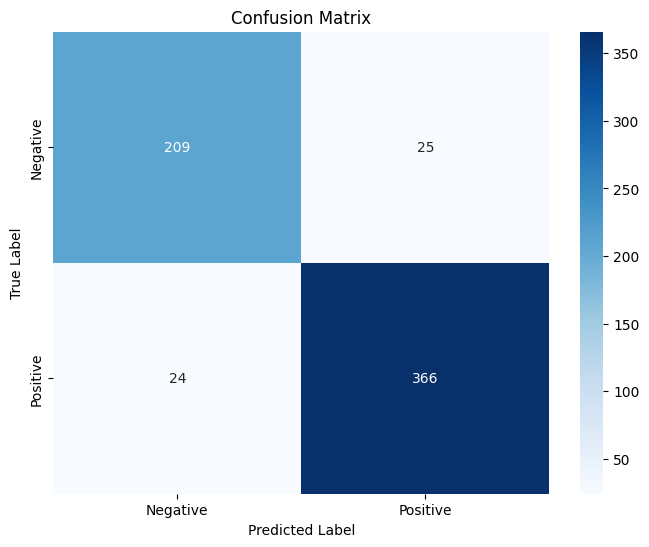

In [22]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, ensemble_binary_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

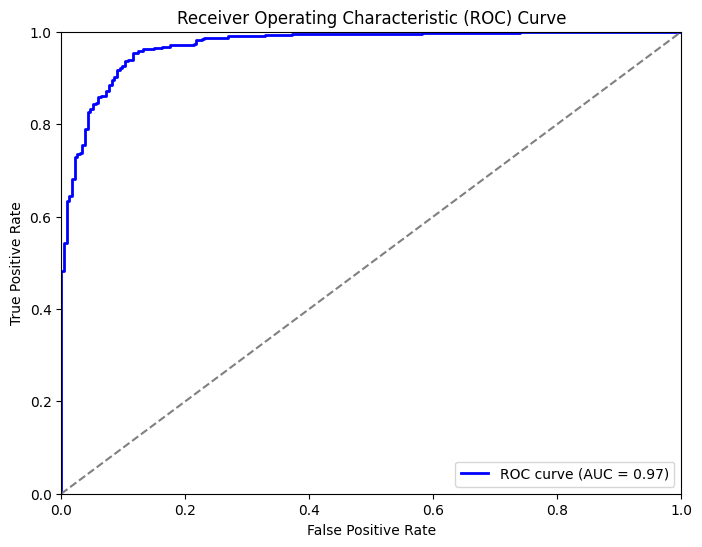

In [23]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, ensemble_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [24]:
# Classification report
class_report = classification_report(y_true, ensemble_binary_preds)
print("\nClassification Report:\n", class_report)

# ROC AUC Score
print("\nROC AUC Score:", roc_auc)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90       234
           1       0.94      0.94      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.92      0.92       624
weighted avg       0.92      0.92      0.92       624


ROC AUC Score: 0.9711264518956827
